# Individual Level Epidemic Models

Susceptible-Infected-Removed (SIR) models make up the core of stochastic epidemic modeling. The simplest case of the model proposes that an population (of size $N$) transitions through three stages. Individuals start in the susceptible stage (unless they are part of the initial infected subset). As a result of interacting with the infected individuals in a population, a susceptible member transitions to the infected stage at a rate $\beta(\cdot)$ which is a function of some covariates. Once infected, these members of the population contribute to the total infectious pressure, infecting other susceptibles or they become removed (recovered - and assumed to be immune, or die) at a rate $\gamma(\cdot)$ which is a function of some covariates.

In this document, we look at performing Bayesian inference on these models with the goal of *correctly* estimating the parameters of the rate functions $(\beta(\cdot), \gamma(\cdot))$. We will be using the 1861 Hagelloch measles data set for this exercise and augment it as necessary.

In [1]:
# preamble - load all packages 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime

from scipy import stats
from sklearn.metrics.pairwise import euclidean_distances

sns.set(rc = {'figure.figsize':(15,8)})

In [2]:
measles = pd.read_csv('measles_hagelloch_1861.csv')

In [3]:
pairwise_distances = euclidean_distances(X=measles[['x_loc', 'y_loc']])

In [4]:
# formating the dates 
measles['date_of_prodrome'] = pd.to_datetime(measles['date_of_prodrome'], format='%Y-%m-%d')
measles['date_of_rash'] = pd.to_datetime(measles['date_of_rash'], format='%Y-%m-%d')
measles['date_of_death'] = pd.to_datetime(measles['date_of_death'], format='%Y-%m-%d')

In [5]:
# fill death time - death is NaN in many cases 
measles['date_of_death'] = measles['date_of_death'].fillna(pd.to_datetime('1/1/2000'))

In [6]:
# to avoid imputing removal time, assume rash + 5 days
measles = measles.assign(
    date_of_removal=lambda df: df.date_of_rash + datetime.timedelta(days=5))
measles = measles.assign(date_of_removal=measles[['date_of_removal', 'date_of_death']].min(axis=1))

In [7]:
# preview the data
measles.head()

,case_ID,infector,date_of_prodrome,date_of_rash,date_of_death,age,gender,family_ID,class,complications,x_loc,y_loc,date_of_removal
0,1,45.0,1861-11-21,1861-11-25,2000-01-01,7,f,41,1,yes,142.5,100.0,1861-11-30
1,2,45.0,1861-11-23,1861-11-27,2000-01-01,6,f,41,1,yes,142.5,100.0,1861-12-02
2,3,172.0,1861-11-28,1861-12-02,2000-01-01,4,f,41,0,yes,142.5,100.0,1861-12-07
3,4,180.0,1861-11-27,1861-11-28,2000-01-01,13,m,61,2,yes,165.0,102.5,1861-12-03
4,5,45.0,1861-11-22,1861-11-27,2000-01-01,8,f,42,1,yes,145.0,120.0,1861-12-02


In [8]:
# order data so initial infective is first row
#measles = measles.sort_values('date_of_prodrome')
measles.head(10)

,case_ID,infector,date_of_prodrome,date_of_rash,date_of_death,age,gender,family_ID,class,complications,x_loc,y_loc,date_of_removal
0,1,45.0,1861-11-21,1861-11-25,2000-01-01,7,f,41,1,yes,142.5,100.0,1861-11-30
1,2,45.0,1861-11-23,1861-11-27,2000-01-01,6,f,41,1,yes,142.5,100.0,1861-12-02
2,3,172.0,1861-11-28,1861-12-02,2000-01-01,4,f,41,0,yes,142.5,100.0,1861-12-07
3,4,180.0,1861-11-27,1861-11-28,2000-01-01,13,m,61,2,yes,165.0,102.5,1861-12-03
4,5,45.0,1861-11-22,1861-11-27,2000-01-01,8,f,42,1,yes,145.0,120.0,1861-12-02
5,6,180.0,1861-11-26,1861-11-29,2000-01-01,12,m,42,2,yes,145.0,120.0,1861-12-04
6,7,42.0,1861-11-24,1861-11-28,2000-01-01,6,m,26,0,yes,272.5,147.5,1861-12-03
7,8,45.0,1861-11-21,1861-11-26,2000-01-01,10,m,44,1,yes,97.5,155.0,1861-12-01
8,9,182.0,1861-11-26,1861-11-30,2000-01-01,13,m,44,2,yes,97.5,155.0,1861-12-05
9,10,45.0,1861-11-21,1861-11-25,2000-01-01,7,f,29,1,yes,240.0,75.0,1861-11-30


The above dataset is a complete epidemic dataset since the dates for each individuals transition through the S-I-R model are recorded. With the model propsed by Neal & Roberts, some data augmentation is needed. The full likelihood of the model is as follows: 

$$f(I,R | \beta, \theta, Z, P, I_k) = \prod_{j \neq k} \left\{ \sum_{i \in I_j} \beta \exp \{ -\theta \kappa(i,j) \} \right\} \exp \left\{ \sum_{j=1}^m \sum_{k=1}^n \lambda_{jk} \{ \min(R_j, I_k) - \min(I_j, I_k ) \} \right\} \prod_{i=1}^m g(S_i - I_i) $$ 
For simplicty, the infectious pressure will be restricted to a spatial component such that $ \lambda_{ij} =  \beta \exp \{ -\theta \kappa(i,j) \} $.
$$ $$
\begin{equation}
    \log f(I,R | \beta, \theta, Z, P, I_k) = \sum_{j \neq k} \log \left( \sum_{i:I_i \leq I_j \leq R_i }   \beta \exp \{ -\theta \kappa(i,j) \right) - \sum_{j=1}^m \sum_{k=1}^n  \beta \exp \{ -\theta \kappa(j,k)\} \{ \min(R_j, I_k) - \min(I_j, I_k ) \} + \sum_{i=1}^m \log f(D_i|\delta)
\end{equation} 

However, since we set the recovery to 5 days, we not longer need to assume those days come from a gamma distribution. The last term in the log-likelihood $\sum_{i=1}^m \log f(D_i|\delta)$ is now just $\sum_{i=1}^m \min \{\text{recovery}_i, \text{death}_i \}$ (regardless of the resulting min, it is a constant w.r.t the parameters and can be dropped).

\begin{equation}
    \log f(I,R | \beta, \theta, Z, P, I_k) \propto \sum_{j \neq k} \log \left( \beta \sum_{i:I_i \leq I_j \leq R_i }  \exp \{ -\theta \kappa(i,j)\} \right) - \sum_{j=1}^m \sum_{k=1}^n  \beta \exp \{ -\theta \kappa(j,k)\} \left[ \min(R_j, I_k) - \min(I_j, I_k ) \right]
\end{equation}

In [9]:
# compute min(I_j, I_k )
pairwise_infections = np.fmin(np.array(measles.date_of_prodrome)[
                              :, None], np.array(measles.date_of_prodrome)[None, :])

# compute min(R_j, I_k)
pairwise_infection_removal = np.fmin(np.array(measles.date_of_prodrome)[
    :, None], np.array(measles.date_of_death)[None, :])

# compute infectious overlap period
pairwise_infectious_overlap = (
    pairwise_infection_removal - pairwise_infections) / np.timedelta64(1, "D")

# A. compute the WAIFW matrix <----- FIX THIS!!! 
WAIFW_mat1 = np.zeros(shape = (len(measles.date_of_prodrome), len(measles.date_of_prodrome)))

for ii in range(len(measles.date_of_prodrome)):
    for jj in range(len(measles.date_of_prodrome)):
        WAIFW_mat1[ii,jj] = (measles.date_of_prodrome[jj] <= measles.date_of_prodrome[ii] <= measles.date_of_removal[jj])

# B. compute the WAIFW matrix <----- FIX THIS!!! 
WAIFW_mat2 = np.zeros(shape = (len(measles.date_of_prodrome), len(measles.date_of_prodrome)))

for ii in range(len(measles.date_of_prodrome)):
    for jj in range(len(measles.date_of_prodrome)):
        WAIFW_mat2[jj,ii] = (measles.date_of_prodrome[ii] <= measles.date_of_prodrome[jj] <= measles.date_of_removal[ii])
        
np.float64(WAIFW_mat2)        

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 1., 0., ..., 1., 0., 1.]])

## MCMC Algorithm 

In [10]:
# try to back out the overall event rate in the population: i.e. run MCMC for an exponential distribution
def ILMepidemic_MCMC(data, init, iters=10001):

    # reorder data
    data = data.sort_values('date_of_prodrome')

    def metropolisHastings(init, logLik, rprop, dprior, iters=iters):
        # initialize matrix to store results
        mat = np.zeros(shape=(iters, len(init)))
        mat[0, :] = init
        accept_counter = 0
        theta = init

        # compute initial logLik
        ll_main = logLik(mat[0, :])

        # run the MCMC for iters many iterations

        for ii in range(iters):
            # propose new parameters
            theta_proposed = rprop(theta)
            # check if proposal is a valid one

            ll_proposed = logLik(theta_proposed)

            # compute the (log) acceptance probability

            a = ll_proposed-ll_main + \
                dprior(theta_proposed) - dprior(theta)
            # print(f"proposal, {theta_proposed}. alpha {a}.")

            if (np.log(stats.uniform(0, 1).rvs()) < a):
                # print('accept')
                theta = theta_proposed
                ll_main = ll_proposed
                accept_counter += 1
                # store the result
                mat[ii, :] = theta
            else:
                # print('reject')
                mat[ii, :] = mat[ii-1, :]

        print(f'MCMC done! Accept prob = {accept_counter/iters}')

        return mat

    # parameters are [beta, theta]
    def proposal_denisty(parameters):
        return stats.norm(parameters, [0.0028322, 0.020008753]).rvs()

    def prior_density(parameters):
        # np.sum(stats.gamma.logpdf(parameters, 3, loc=0, scale=1))
        return np.sum(stats.gamma.logpdf(parameters, 3, loc=0, scale=0.1))

    def logLik(parameters):
        # attempt 2
        part1 = np.sum(np.delete(parameters[0] * WAIFW_mat2 * np.exp(- parameters[1]
                       * pairwise_distances), identify_initial_infected(), axis=0), axis=1)
        part1 = np.sum(np.log(part1))
        
        part2 = np.sum(parameters[0] * np.exp(- parameters[1]
                       * pairwise_distances) * pairwise_infectious_overlap)
        return part1 - part2

    def identify_initial_infected():
        return data.date_of_prodrome.argmin()

    ####################################################################################
    return metropolisHastings(init=init,
                              logLik=logLik,
                              rprop=proposal_denisty,
                              dprior=prior_density)


MCMC_results = ILMepidemic_MCMC(data=measles, init=[0.1, 0.1])

MCMC done! Accept prob = 0.838016198380162


array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

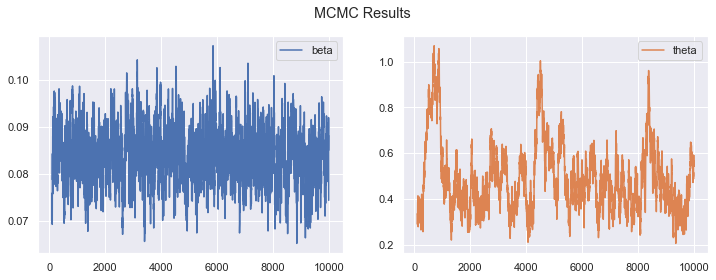

In [11]:
pd.DataFrame(MCMC_results, columns=['beta', 'theta']).loc[100:,:].plot(
    title='MCMC Results',
    figsize=(12, 4),
    subplots=True,
    layout=(1, 2))

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>]],
      dtype=object)

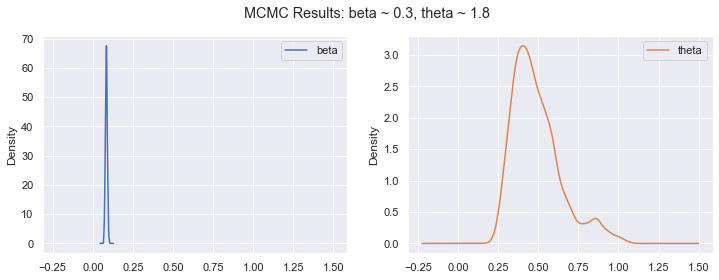

In [12]:
pd.DataFrame(MCMC_results, columns=['beta', 'theta']).loc[100:,:].plot(
    title='MCMC Results: beta ~ 0.3, theta ~ 1.8',
    kind = 'kde',
    figsize=(12, 4),
    subplots=True,
    layout=(1, 2))

In the Neal & Roberts paper, theta has mean of 1.8 but the distances are scaled by 2.5m. Our estimate of 0.34 can be scaled by 1:2.5 (i.e by 5) to get a reasonable close match. 

In [13]:
pd.DataFrame(MCMC_results, columns=['beta', 'theta']).loc[1000:,:].describe()

,beta,theta
count,9001.000000,9001.000000
mean,0.083896,0.470196
std,0.006107,0.128672
min,0.065170,0.206503
25%,0.079838,0.375792
50%,0.083929,0.450844
75%,0.087859,0.546220
max,0.107348,1.003489


## Expanding the Model 

Given the rich nature of the data set, additional covariates such as the gender, class, and age  can be introduced into the model. These additional covariates show up in the likelihood and the only modification to the above code that the parameter vector expands (and likelihood formula changes). 

# To TensorFlow



In [14]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

tfd = tfp.distributions

In [15]:
# some tfp objects 
normal = tfd.Normal(loc = 3, scale = 1.5)

2022-04-27 12:53:02.905729: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/Users/alinmorariu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


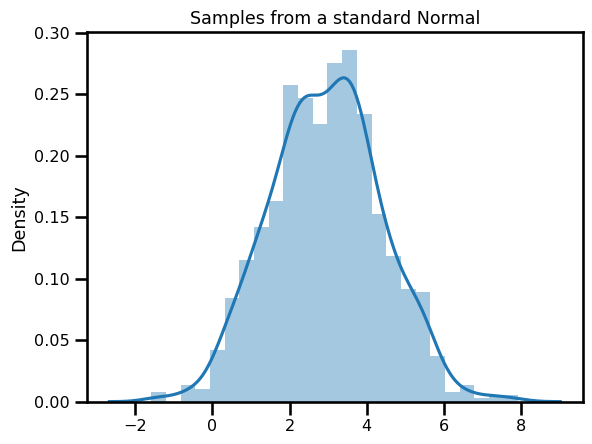

In [16]:
samples = normal.sample(1000)
sns.distplot(samples)
plt.title("Samples from a standard Normal")
plt.show()

/Users/alinmorariu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alinmorariu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alinmorariu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

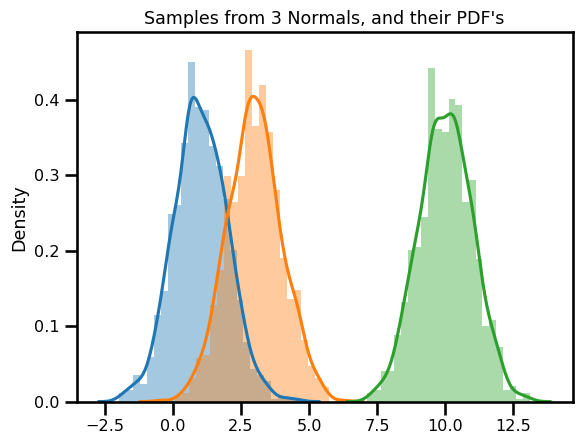

In [17]:
# can also put vectors into the location to get samples from different mean'd distributions 
many_normals = tfd.Normal(loc = [1, 3, 10], scale = 1)

many_samples = many_normals.sample(1000)
# Summarizing visually
for i in range(3):
  sns.distplot(many_samples[:, i], kde=True, norm_hist=True)
plt.title("Samples from 3 Normals, and their PDF's")
plt.show()

In [18]:
# convert the precomputed quantitie to tf constants 
pairwise_distances_tf = tf.constant(pairwise_distances)

pairwise_infectious_overlap_tf = tf.constant(pairwise_infectious_overlap)
pairwise_infectious_overlap_tf = tf.cast(pairwise_infectious_overlap_tf, dtype = tf.float64)

WAIFW_mat_tf = tf.constant(WAIFW_mat2)
WAIFW_mat_tf = tf.cast(WAIFW_mat_tf, dtype= tf.float64)
# initialize parameters 
parameters_tf = tf.cast(tf.Variable([0.1, 0.1]), dtype=tf.float64)

In [36]:
# naive conversion to tfp -> change most np statements to tfp statements
def ILM_epidemic_MCMC_tf(data=measles, init=[0.1, 0.1], iters=10001):
    '''
    Tensorflow adaptation of the ILM_epidemic MCMC sampler above
    '''
    dtype = np.float64
    # initializations
    init = dtype(init)

    def log_target_prob(parameters):
        '''
        Target distribution of the MCMC - in a tf style
        '''

        def prior_density(parameters):
            '''
            Compute prior probability of parameters
            '''
            prior_beta = tfd.Gamma(concentration=dtype(3.0), rate=dtype(10.0))
            prior_theta = tfd.Gamma(concentration=dtype(3.0), rate=dtype(10.0))

            return prior_beta.log_prob(parameters[0]) + prior_theta.log_prob(parameters[1])

        part1 = tf.einsum('ij->i', tf.gather(parameters[0] * WAIFW_mat_tf * tf.math.exp(- parameters[1] * pairwise_distances_tf),
                          initial_infected_individual(),
                          axis=0))
        # above shrinks dimension to nx1 so next einsum needs only be a column vectoe summation
        part1 = dtype(tf.einsum('i->', tf.math.log(part1)))

        part2 = dtype(tf.einsum('ij->', (parameters[0] * tf.math.exp(- parameters[1]
                                                                     * pairwise_distances_tf)) * pairwise_infectious_overlap_tf))

        return (part1 - part2) + dtype(prior_density(parameters))

    def initial_infected_individual():
        '''
        Provides list of indices to use within tf.gather() function in order to
            drop the initial infective from the log-likelihood computation and avoid errors.
        '''
        temp_list = list(range(len(data.date_of_prodrome)))
        temp_list.pop(data.date_of_prodrome.argmin())
        return temp_list

    # use tfp to do MCMC

    samples, results = tfp.mcmc.sample_chain(
        num_results=1000,
        num_burnin_steps=100,
        current_state=init,
        kernel=tfp.mcmc.RandomWalkMetropolis(log_target_prob,
                                             new_state_fn=tfp.mcmc.random_walk_normal_fn(
                                                 scale=0.01, name=None
                                             ))
    )

    sample_mean = tf.math.reduce_mean(samples, axis=0)
    sample_std = tf.sqrt(
        tf.math.reduce_mean(
            tf.math.squared_difference(samples, sample_mean),
            axis=0))

    return sample_mean, sample_std, tf.math.reduce_mean(tf.cast(results.is_accepted, dtype=dtype))

In [37]:
ILM_epidemic_MCMC_tf()

/Users/alinmorariu/opt/anaconda3/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


(<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.08352933, 0.37692998])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.00598972, 0.06282445])>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.57>)

In [67]:

def SLR():
    features = np.random.uniform(size = 10)
    
    def model():   
        # initial line that is always needed, wrapper to indicate there is nothing feeding into them
        Root = tfd.JointDistributionCoroutine.Root

        intercept = yield Root(tfd.Normal(loc = tf.constant(0.0), scale = tf.constant(10.0), name = 'intercept'))
        slope = yield Root(tfd.Normal(loc = tf.constant(0.0), scale = tf.constant(1.0), name = 'slope'))
        variance = yield Root(tfd.Gamma(concentration=tf.constant(3.0), rate=tf.constant(10.0), name = 'var'))
        mu = intercept + slope*features 

        y = yield tfd.Independent(
            tfd.Normal(loc = mu, scale = variance),
            reinterpreted_batch_ndims = 1,
            name='y'
        )
    
    return model

                              
simple_model = tfd.JointDistributionCoroutine(SLR())                        

In [68]:
thing1 = simple_model.sample()

In [69]:
thing1

StructTuple(
  intercept=<tf.Tensor: shape=(), dtype=float32, numpy=-12.005955>,
  slope=<tf.Tensor: shape=(), dtype=float32, numpy=0.14990993>,
  var=<tf.Tensor: shape=(), dtype=float32, numpy=0.1809983>,
  y=<tf.Tensor: shape=(10,), dtype=float32, numpy=
    array([-11.846318 , -11.8342   , -12.160805 , -11.996848 , -11.695578 ,
           -11.849106 , -12.301967 , -11.674276 , -11.725617 , -11.8149805],
          dtype=float32)>
)

In [70]:
simple_model.log_prob(thing1)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.3529947>

In [71]:
conditional_model = simple_model.experimental_pin(y=thing1.y)

In [74]:
current_state = conditional_model.sample_unpinned()

kernel = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=conditional_model.log_prob,
    new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1))

samples, results = tfp.mcmc.sample_chain(num_results=1000, kernel=kernel, current_state=current_state)

/Users/alinmorariu/opt/anaconda3/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [75]:
samples

StructTuple(
  intercept=<tf.Tensor: shape=(1000,), dtype=float32, numpy=
    array([ 8.1766291e+00,  8.1766291e+00,  8.1766291e+00,  8.2105408e+00,
            8.1609116e+00,  8.1609116e+00,  8.1708145e+00,  8.1708145e+00,
            8.1708145e+00,  8.1708145e+00,  8.1708145e+00,  8.1708145e+00,
            8.1817007e+00,  8.1817007e+00,  8.4102983e+00,  8.4843168e+00,
            8.5248756e+00,  8.5248756e+00,  8.6005831e+00,  8.6005831e+00,
            8.6005831e+00,  8.5138826e+00,  8.4470539e+00,  8.4470539e+00,
            8.5008898e+00,  8.5008898e+00,  8.5008898e+00,  8.4543686e+00,
            8.3554602e+00,  8.3810616e+00,  8.3810616e+00,  8.3810616e+00,
            8.4061317e+00,  8.3093739e+00,  8.2369843e+00,  8.2369843e+00,
            8.1364222e+00,  8.1239262e+00,  8.1434746e+00,  8.2097864e+00,
            8.2097864e+00,  8.2945108e+00,  8.2945108e+00,  8.2945108e+00,
            8.2945108e+00,  8.2190685e+00,  8.2190685e+00,  8.2868891e+00,
            8.2928572e+00,